In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from Import_Functions import import_npy
from Global_Units import IMAGE_PRAMS
import Signal_Threshold as ST
import scipy.ndimage as ndimage

Define some usefull Globals for this notebook

In [2]:
GLOBALS = {
    "Filtering": False,
    "Filtering_Scale_Optimal": 0
}

In [3]:
#find all the files in DATA directory
files = os.listdir(IMAGE_PRAMS['DATA_PATH'])
#make a list of the files that end in .npy
npy_files = [file for file in files if file.endswith('.npy')]


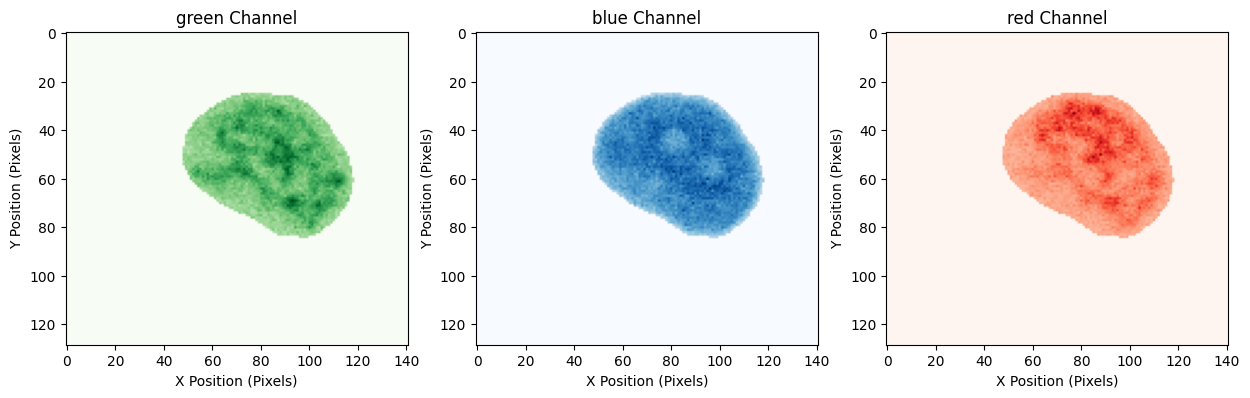

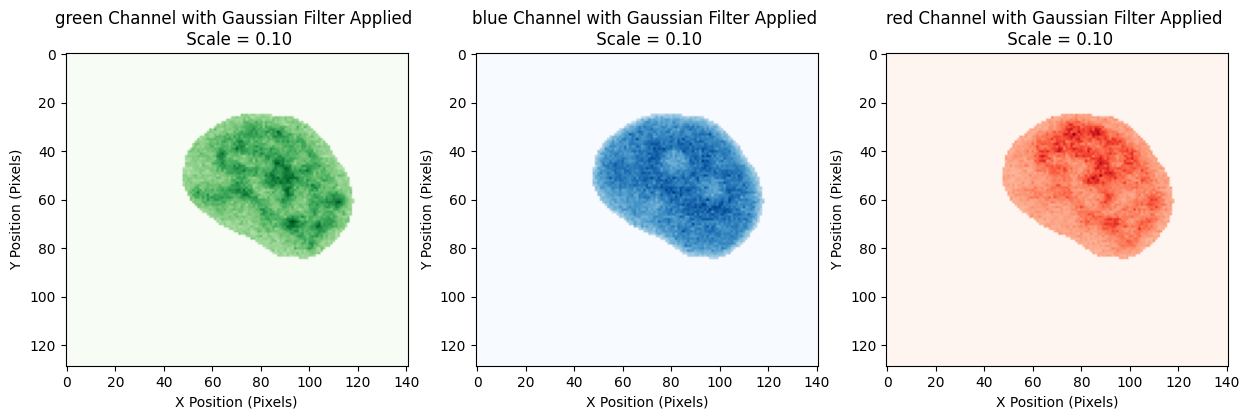

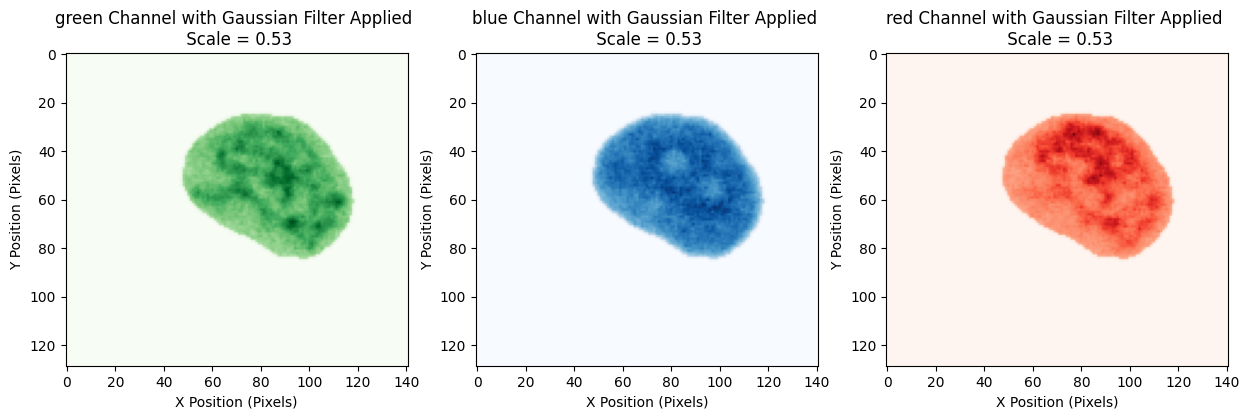

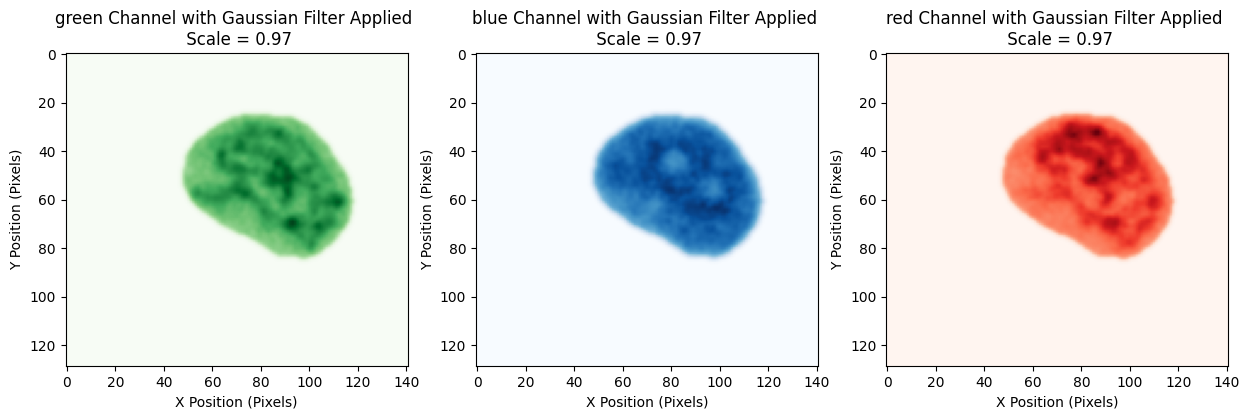

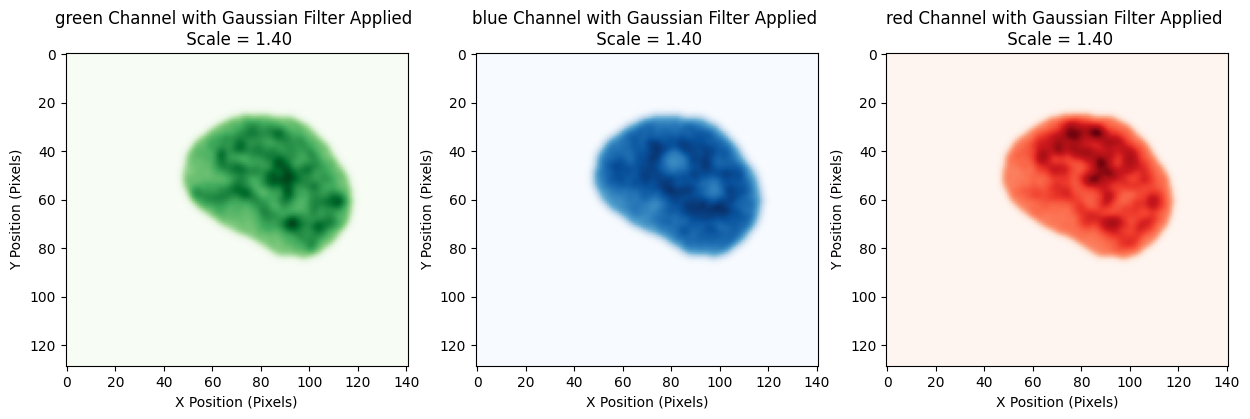

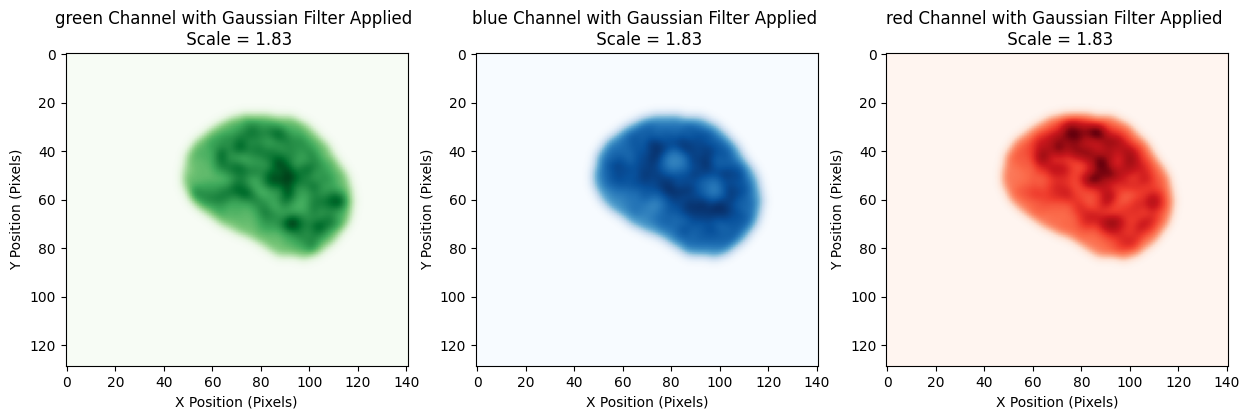

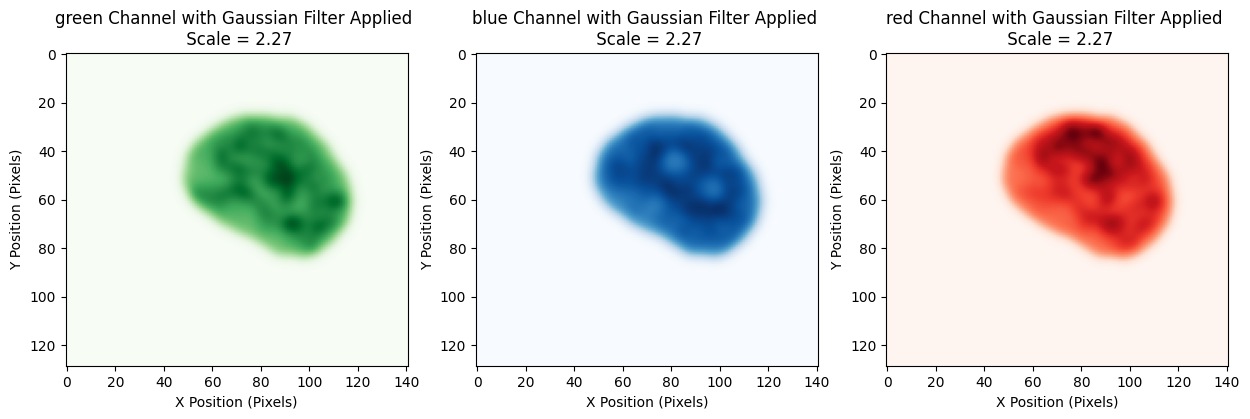

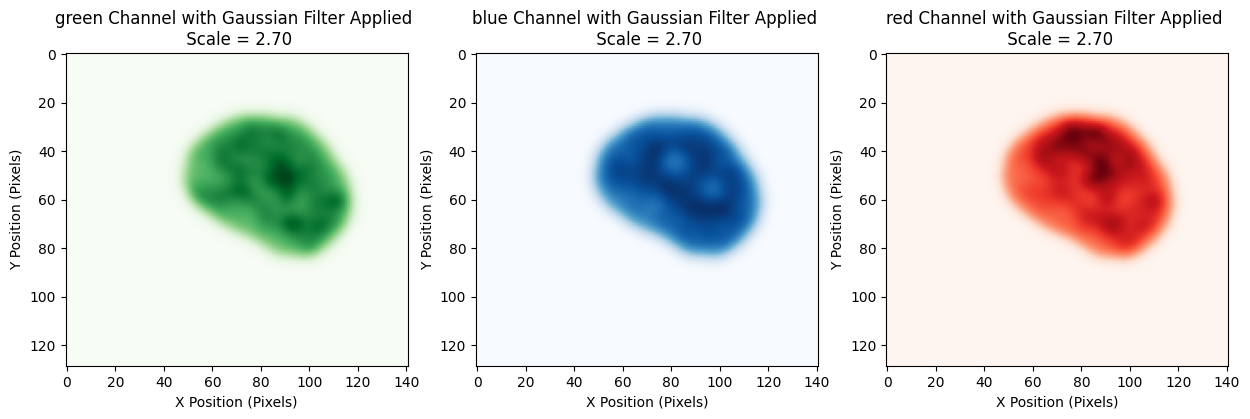

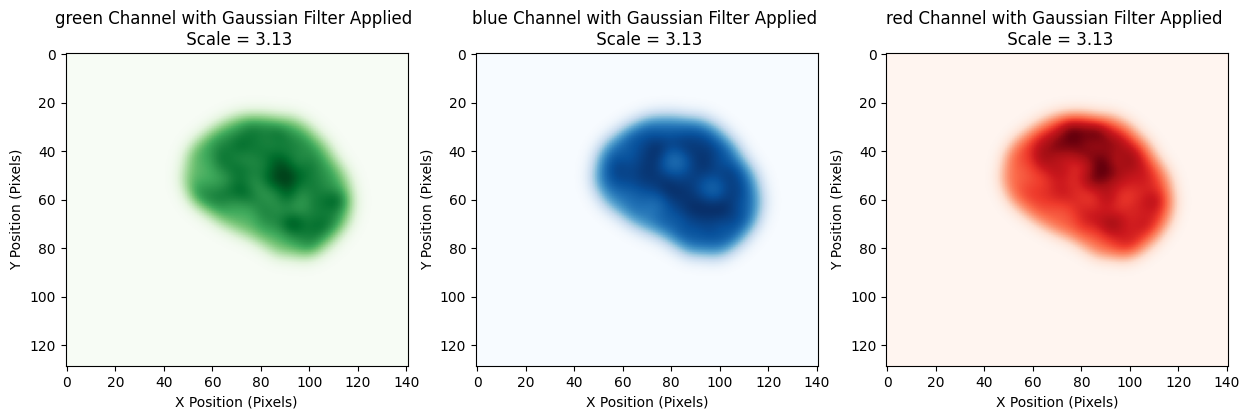

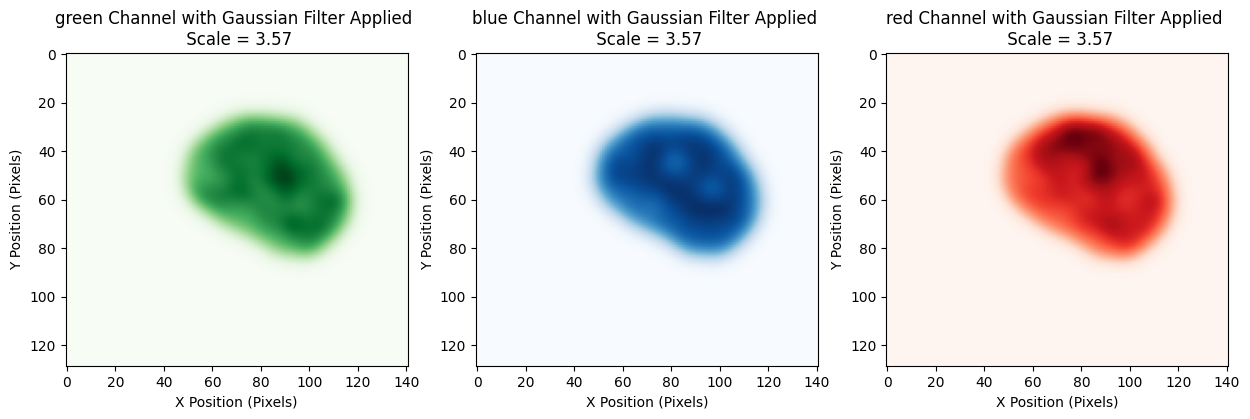

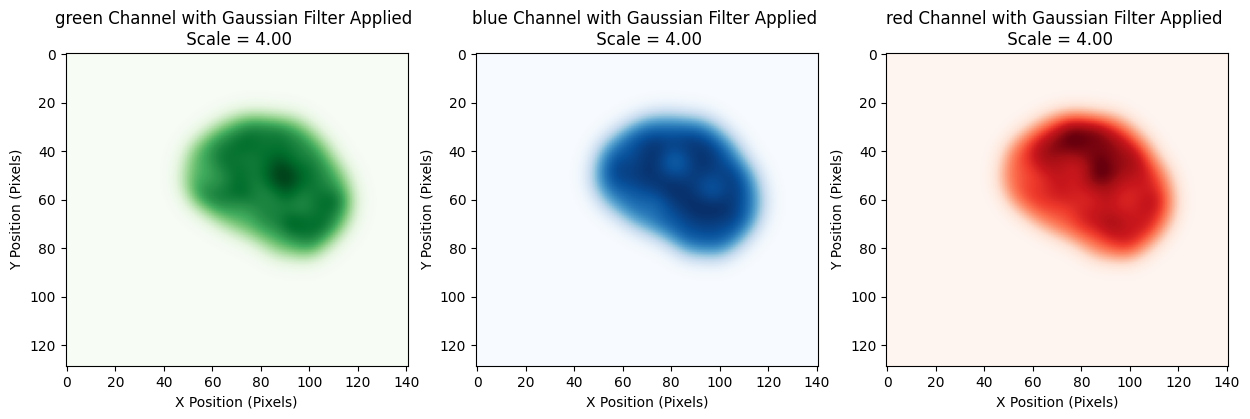

In [4]:
#open each file and store the 2D array in a dictionary based on the file name
data = {}
for file in npy_files:
    #import the data
    #the key for the dictionary is the color of the channel based on "Channel_Names" in Global_Units.py
    #using the first word_ in the file name as the key
    data[file.split('_')[0]] = import_npy(os.path.join(IMAGE_PRAMS['DATA_PATH'],file))


#plot the imshow of the data but with colorbar that is the same color as the string key
fig,ax = plt.subplots(1,3,figsize=(15,5))
for i,key in enumerate(data.keys()):
    #plot the data
    #find the index of the key in "Channel_Colors" in Global_Units.py
    index = IMAGE_PRAMS['Channel_Colors'].index(key)
    #use the index to find the colorbar name in "Channel_Colorbar" in Global_Units.py
    colorbar = IMAGE_PRAMS['Channel_Colorbar'][index]
    ax[i].imshow(data[key],cmap=colorbar)
    #label the axes
    ax[i].set_xlabel('X Position (Pixels)')
    ax[i].set_ylabel('Y Position (Pixels)')
    #make the title
    ax[i].set_title(f'{key} Channel')
plt.show()

#lets do the same but by applying a gaussian filter to the data before plotting (use a range of scale and make the title of the plot the scale)
scale_scan = np.linspace(0.1,4,10)
for k in scale_scan:
    fig,ax = plt.subplots(1,3,figsize=(15,5))
    for i,key in enumerate(data.keys()):
        #plot the data
        #find the index of the key in "Channel_Colors" in Global_Units.py
        index = IMAGE_PRAMS['Channel_Colors'].index(key)
        #use the index to find the colorbar name in "Channel_Colorbar" in Global_Units.py
        colorbar = IMAGE_PRAMS['Channel_Colorbar'][index]
        ax[i].imshow(ndimage.gaussian_filter(data[key],sigma=k),cmap=colorbar)
        #label the axes
        ax[i].set_xlabel('X Position (Pixels)')
        ax[i].set_ylabel('Y Position (Pixels)')
        #make the title
        #make the k printing to 2 decimal places
        ax[i].set_title(f'{key} Channel with Gaussian Filter Applied \n Scale = {k:.2f}')
    plt.show()

if GLOBALS['Filtering']:
    #lets choose the optimal scale to be 1 from inspection from the scale_scan plot
    GLOBALS['Filtering_Scale_Optimal'] = 1
    #lets change the values in data to be scaled by the gaussian fitler with scale = optimal_scale
    for key in data.keys():
        data[key] = ndimage.gaussian_filter(data[key],sigma=GLOBALS['Filtering_Scale_Optimal'])



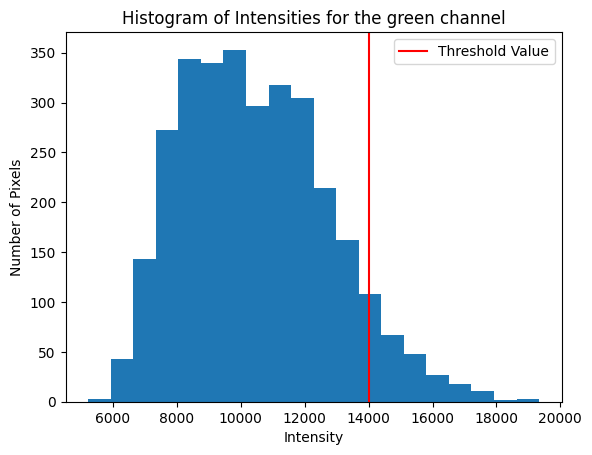

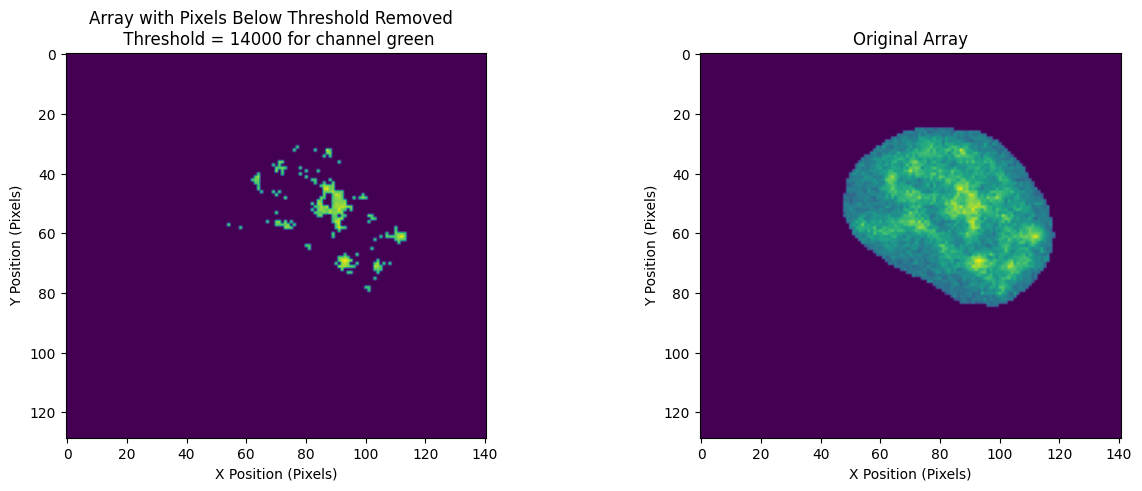

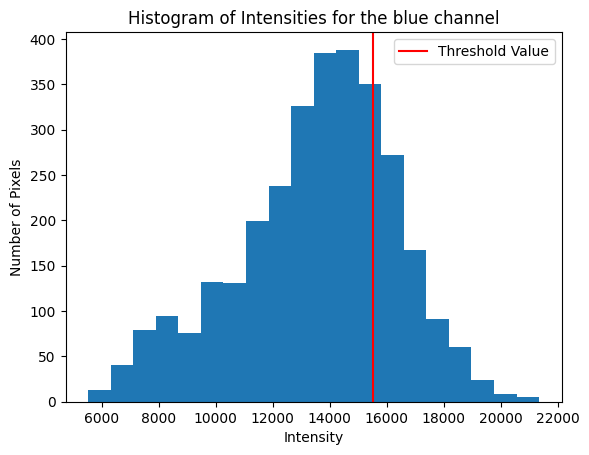

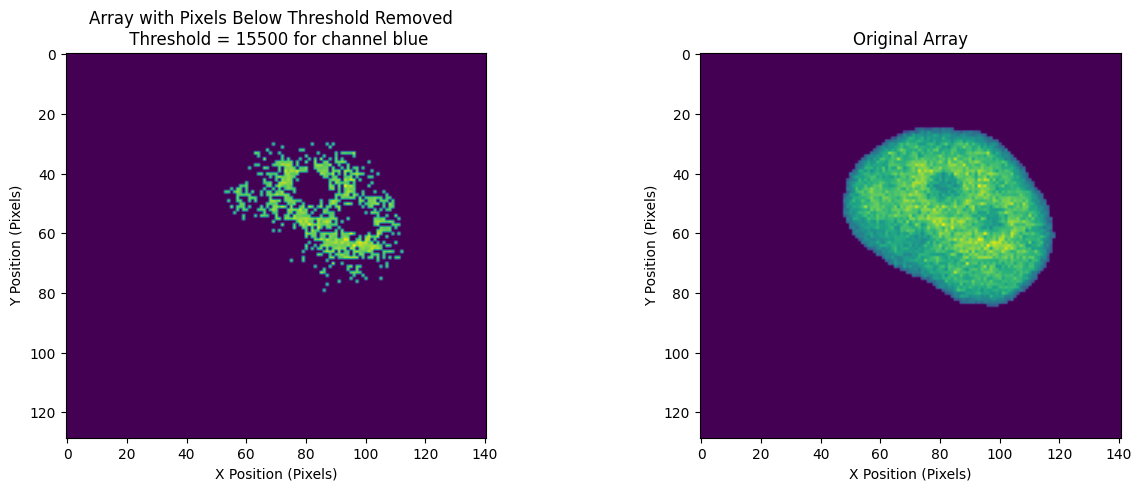

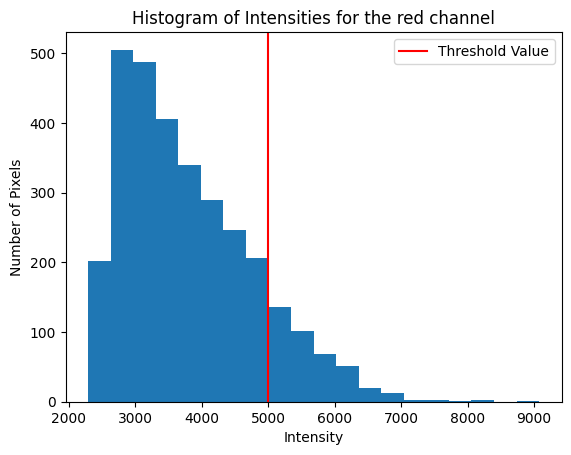

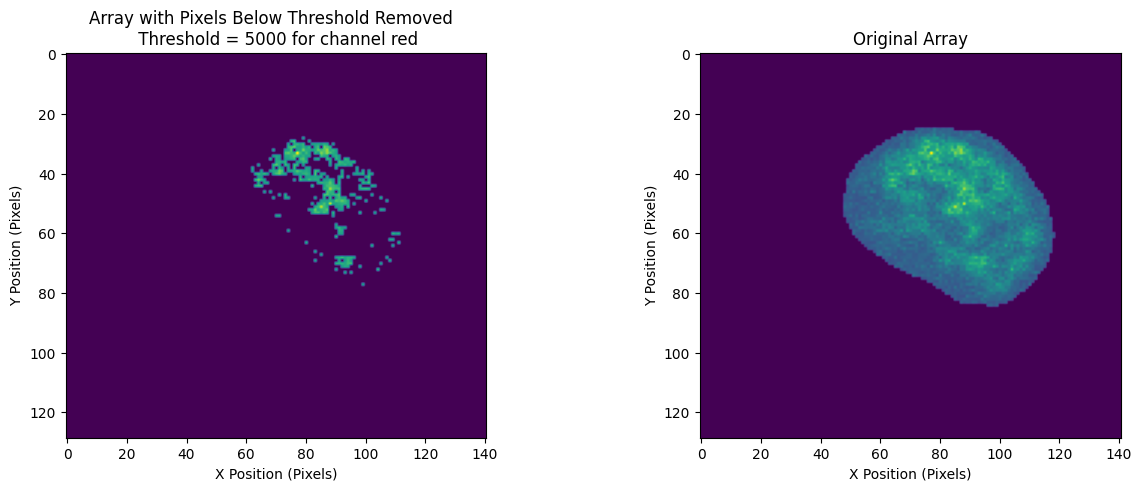

In [5]:
threshold_guesses = {
    "red": 5000,
    "green": 14000,
    "blue": 15500,
}
#do the thresholding for each channel
thresholded_data = {}
for key in data.keys():
    #find the threshold for the data
    threshold,thresholded_data[key] = ST.signal_threshold(data[key],threshold_guess=threshold_guesses[key],plot=True,ignore_zero=True,name=key)

In [6]:
#using the thresholded guesses, calculate the thresholded_array() for each channel
thresholded_arrays= {}
for key in data.keys():
    thresholded_arrays[key] = ST.threshold_array(data[key],threshold_guesses[key])

In [7]:
#find all unique permutations of size 2 from the keys in the dictionary
#ie red:green, red:blue, green:blue
def unique_permutation(keys):
    '''Docstring for unique_permutation
    Parameters:
    -----------
    keys: list
        A list of strings
    Returns:
    --------
    unique_permutations: list
        A list of tuples of strings
    '''
    #make a list of all the permutations of size 2
    permutations = [(key1,key2) for i,key1 in enumerate(keys) for key2 in keys[i+1:]]
    #make a list of all the unique permutations
    unique_permutations = []
    for permutation in permutations:
        #if the permutation is not in the list of unique permutations, add it
        if permutation not in unique_permutations:
            unique_permutations.append(permutation)
    return unique_permutations

key_permutations = unique_permutation(list(data.keys()))
print(key_permutations)


[('green', 'blue'), ('green', 'red'), ('blue', 'red')]


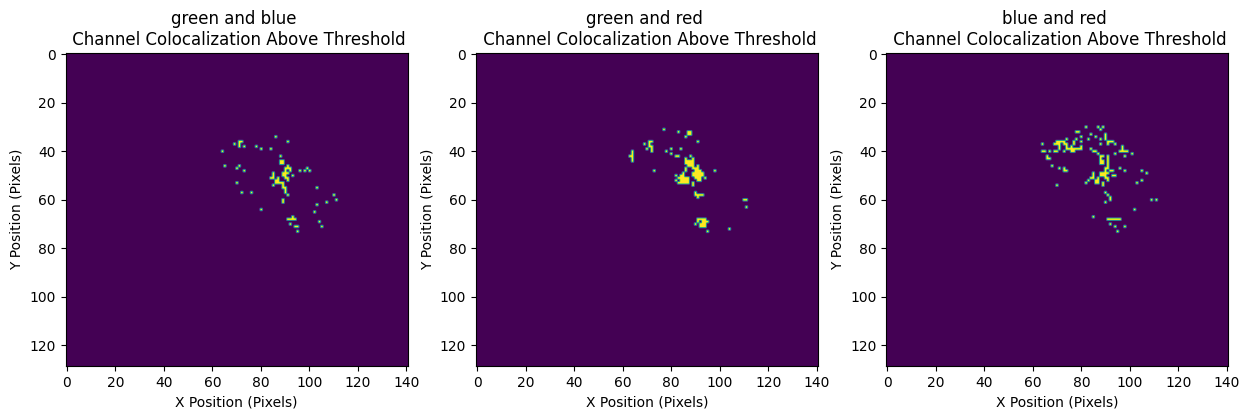

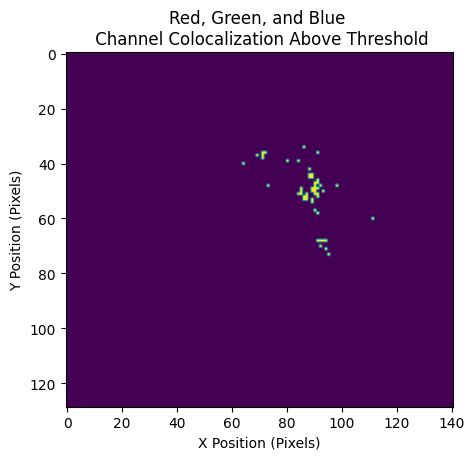

In [8]:
#for each unique permutation, apply the and operator to the thresholded arrays
#and plot the result as an imshow
fig,ax = plt.subplots(1,len(key_permutations),figsize=(15,5))
for i,permutation in enumerate(key_permutations):
    #apply the and operator
    result = ST.and_gate(thresholded_arrays[permutation[0]],thresholded_arrays[permutation[1]])
    #plot the result
    ax[i].imshow(result)
    #label the axes
    ax[i].set_xlabel('X Position (Pixels)')
    ax[i].set_ylabel('Y Position (Pixels)')
    #make the title
    ax[i].set_title(f'{permutation[0]} and {permutation[1]} \n Channel Colocalization Above Threshold')
plt.show()
#now do this for all three channels
total_colocalization = ST.and_gate(thresholded_arrays['red'],thresholded_arrays['green'],thresholded_arrays['blue'])
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(total_colocalization)
ax.set_xlabel('X Position (Pixels)')
ax.set_ylabel('Y Position (Pixels)')
ax.set_title(f'Red, Green, and Blue \n Channel Colocalization Above Threshold')
plt.show()